# Computer Vision

### Egy Vedriyanto
### 2117051035

Studi Kasus:

Klasifikasi gambar kupu-kupu dari 8 jenis berbeda yang masing-masing jenis memiliki kurang lebih 100 gambar berbeda.

Model yang akan saya gunakan antara lain
1.   MobileNet-v2
2.   AlexNet
3.   ResNet

## Implementasi

### Library

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import os

### Dataset

In [2]:
# Mengimpor drive Google ke lingkungan Colab
from google.colab import drive
drive.mount('/content/drive')

# Mendefinisikan path ke dataset gambar kupu-kupu di Google Drive
dataset_path = '/content/drive/My Drive/Computer Vision/butterfly_dataset'

Mounted at /content/drive


In [3]:
os.listdir(dataset_path)

['kupu_jojo',
 'kupu_raja_limau',
 'kupu_hijau_biru',
 'kupu_raja_helena',
 'kupu_pantat_merah',
 'kupu_jarak',
 'kupu_harimau_kuning_hijau',
 'kupu_batik_cap']

### Dataset preprocessing

Classes: ['kupu_batik_cap', 'kupu_harimau_kuning_hijau', 'kupu_hijau_biru', 'kupu_jarak', 'kupu_jojo', 'kupu_pantat_merah', 'kupu_raja_helena', 'kupu_raja_limau']
Number of images: 795


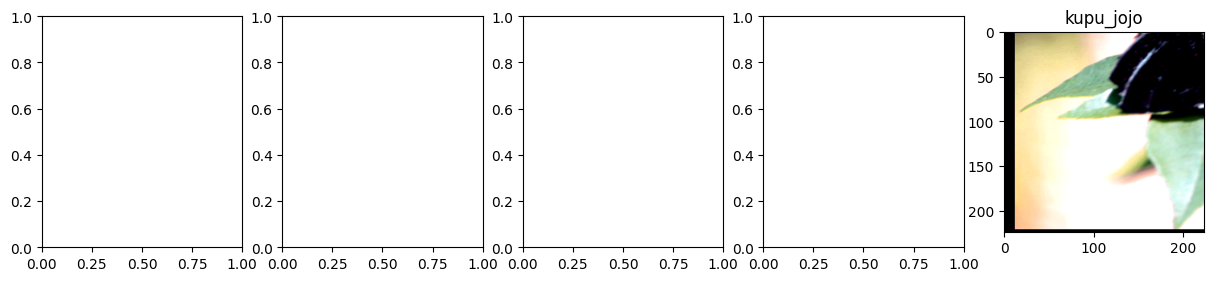

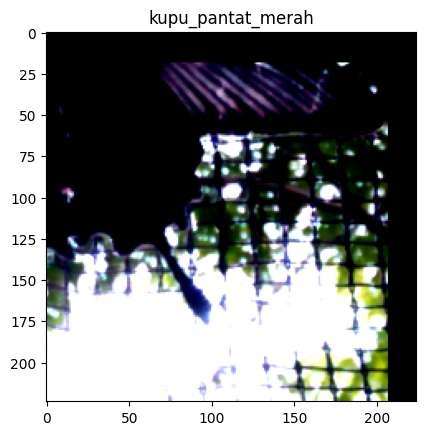

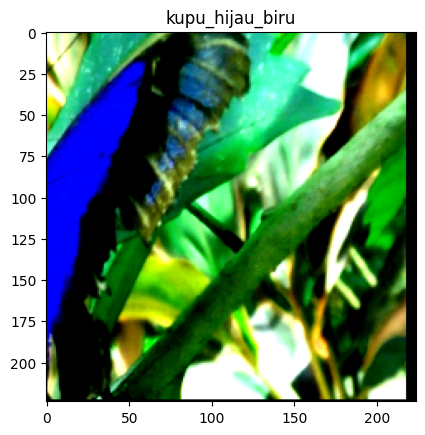

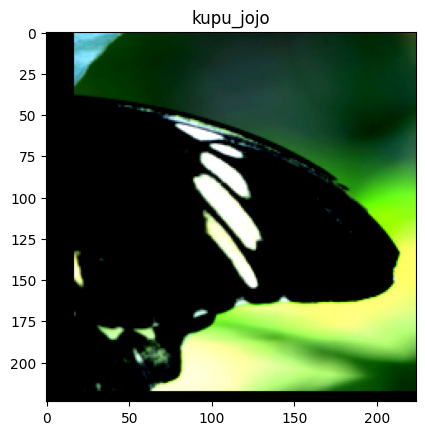

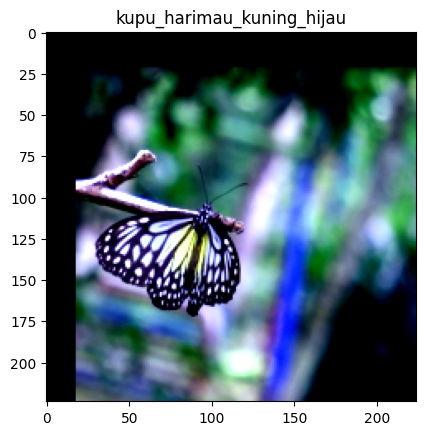

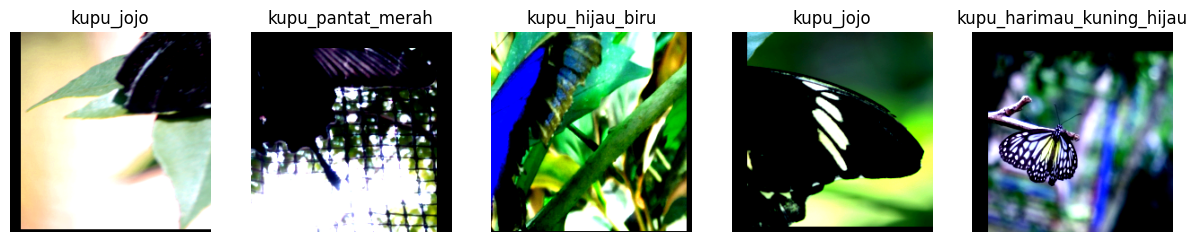

In [4]:
# Transformasi untuk preprocessing data
data_transform = transforms.Compose([
    transforms.RandomResizedCrop((224, 224)),  # Scale (cropping gambar dengan ukuran acak)
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),  # Translate (menggeser gambar dengan batas tertentu)
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Color Space (mengubah brightness, contrast, saturation, dan hue)
    transforms.ToTensor(),  # Mengubah gambar menjadi tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalisasi gambar
])

# Memuat dataset dari directory
dataset = datasets.ImageFolder(root=dataset_path, transform=data_transform)

# Membuat DataLoader untuk mempermudah iterasi data
data_loader = DataLoader(dataset, batch_size=32, shuffle=True)

# Menampilkan daftar dataset
print("Classes:", dataset.classes)
print("Number of images:", len(dataset))

# Fungsi untuk menampilkan beberapa sampel gambar dari dataset
def imshow(img, title):
    img = img / 2 + 0.5  # Unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.title(title)
    plt.show()

# Mengambil batch pertama dari data_loader
data_iter = iter(data_loader)
images, labels = next(data_iter)

# Menampilkan beberapa sampel gambar
fig, axes = plt.subplots(1, 5, figsize=(15, 3))
for i in range(5):
    imshow(images[i], title=dataset.classes[labels[i]])

# Menampilkan grid gambar dengan title
def show_images_grid(images, labels, classes):
    fig, axes = plt.subplots(1, len(images), figsize=(15, 3))
    for i, img in enumerate(images):
        img = img / 2 + 0.5  # Unnormalize
        npimg = img.numpy()
        axes[i].imshow(np.transpose(npimg, (1, 2, 0)))
        axes[i].set_title(classes[labels[i]])
        axes[i].axis('off')
    plt.show()

# Menampilkan grid gambar
show_images_grid(images[:5], labels[:5], dataset.classes)

In [5]:
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

#Memisahkan Data Validasi
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

batch_size = 32

# Buat DataLoader untuk data latih dan data validasi
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

### Modeling

In [6]:
# Memeriksa apakah GPU tersedia
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [7]:
import torchvision

# Menggunakan MobileNetV2
mobilenet_v2 = torchvision.models.mobilenet_v2(pretrained=True)
print("Struktur model mobilenet_v2")
print(mobilenet_v2)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 75.3MB/s]


Struktur model mobilenet_v2
MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
       

In [8]:
# Menggunakan AlexNet
alexnet = torchvision.models.alexnet(pretrained=True)
print("Struktur model alexnet")
print(alexnet)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:01<00:00, 156MB/s]


Struktur model alexnet
AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_feat

In [9]:
# Menggunakan ResNet-50
resnet50 = torchvision.models.resnet50(pretrained=True)
print("Struktur model resnet50")
print(resnet50)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 131MB/s]


Struktur model resnet50
ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_

#### MobileNet V2

In [10]:
# 1. MobileNet-v2

# Ambil dataset asli sebelum dibagi
original_dataset = train_dataset.dataset

# Hitung jumlah kelas dari dataset asli
num_classes = len(original_dataset.classes)

# Membuat model baru
num_features = mobilenet_v2.features[-1].out_channels  # Jumlah fitur masuk untuk lapisan terakhir
mobilenet_v2.classifier = nn.Sequential(
    nn.Linear(num_features, 512),
    nn.ReLU(inplace=True),
    nn.Dropout(0.5),
    nn.Linear(512, num_classes)
)

# Menentukan device yang akan digunakan (CPU atau CUDA jika tersedia)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Memindahkan model ke device yang dipilih
mobilenet_v2 = mobilenet_v2.to(device)

# Definisi loss function dan optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(mobilenet_v2.parameters(), lr=0.001)

TRAINING MODEL MobileNet-V2

In [11]:
# Tentukan jumlah epoch
num_epochs = 10

# Definisikan loss function dan optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(mobilenet_v2.parameters(), lr=0.001)

# Tentukan device yang akan digunakan (CPU atau CUDA jika tersedia)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Memindahkan model ke device yang dipilih
mobilenet_v2 = mobilenet_v2.to(device)

# Loop pelatihan untuk setiap epoch
for epoch in range(num_epochs):
    # Set model ke mode pelatihan
    mobilenet_v2.train()

    # Inisialisasi nilai loss dan jumlah batch yang benar
    running_loss = 0.0
    correct = 0

    # Loop pelatihan untuk setiap batch dalam DataLoader
    for images, labels in train_loader:
        # Memindahkan data ke device yang dipilih
        images, labels = images.to(device), labels.to(device)

        # Reset gradien parameter
        optimizer.zero_grad()

        # Proses forward pass: menghitung output dari model
        outputs = mobilenet_v2(images)

        # Hitung loss
        loss = criterion(outputs, labels)

        # Proses backward pass: hitung gradien dari loss terhadap parameter
        loss.backward()

        # Optimize parameter
        optimizer.step()

        # Hitung statistik untuk logging
        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()

    # Hitung rata-rata loss dan akurasi untuk epoch ini
    epoch_loss = running_loss / len(train_dataset)
    epoch_acc = correct / len(train_dataset)

    # Cetak statistik pelatihan untuk setiap epoch
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}')


Epoch 1/10, Loss: 0.5711, Accuracy: 0.8333
Epoch 2/10, Loss: 0.3328, Accuracy: 0.8915
Epoch 3/10, Loss: 0.2631, Accuracy: 0.9261
Epoch 4/10, Loss: 0.2665, Accuracy: 0.9324
Epoch 5/10, Loss: 0.2869, Accuracy: 0.9135
Epoch 6/10, Loss: 0.1502, Accuracy: 0.9591
Epoch 7/10, Loss: 0.1095, Accuracy: 0.9733
Epoch 8/10, Loss: 0.2055, Accuracy: 0.9450
Epoch 9/10, Loss: 0.2039, Accuracy: 0.9245
Epoch 10/10, Loss: 0.1251, Accuracy: 0.9654


MODEL EVALUATION MobileNet-V2

In [12]:
# Set model ke mode evaluasi
mobilenet_v2.eval()

# Inisialisasi variabel untuk evaluasi
correct = 0
total = 0

# Tidak perlu melacak gradien saat melakukan evaluasi
with torch.no_grad():
    for images, labels in val_loader:
        # Memindahkan data ke device yang dipilih
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = mobilenet_v2(images)

        # Ambil prediksi
        _, predicted = torch.max(outputs, 1)

        # Hitung jumlah data yang diprediksi dengan benar
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

# Hitung akurasi
accuracy = correct / total
print(f'Accuracy on validation set: {accuracy:.2f}')

Accuracy on validation set: 0.93


MODEL REPORTS MobileNet_v2

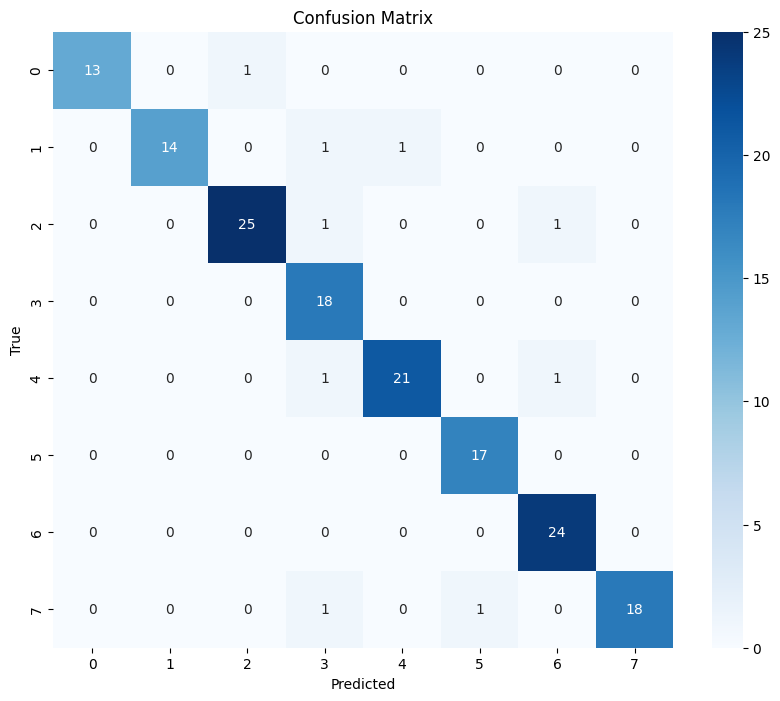

In [13]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Mengumpulkan label sebenarnya
true_labels = []
predicted_labels = []

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = mobilenet_v2(images)
        _, predicted = torch.max(outputs, 1)
        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(predicted.cpu().numpy())

# Hitung confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Tampilkan confusion matrix dengan heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [14]:
# Menghitung TP, FP, TN, dan FN untuk setiap label
for i in range(conf_matrix.shape[0]):
    tp = conf_matrix[i, i]
    fp = conf_matrix[:, i].sum() - tp
    fn = conf_matrix[i, :].sum() - tp
    tn = conf_matrix.sum() - (tp + fp + fn)

    # Menampilkan nilai untuk setiap label
    print(f'Label {i+1}:')
    print(f'True Positive (TP): {tp}')
    print(f'False Positive (FP): {fp}')
    print(f'True Negative (TN): {tn}')
    print(f'False Negative (FN): {fn}')
    print()

Label 1:
True Positive (TP): 13
False Positive (FP): 0
True Negative (TN): 145
False Negative (FN): 1

Label 2:
True Positive (TP): 14
False Positive (FP): 0
True Negative (TN): 143
False Negative (FN): 2

Label 3:
True Positive (TP): 25
False Positive (FP): 1
True Negative (TN): 131
False Negative (FN): 2

Label 4:
True Positive (TP): 18
False Positive (FP): 4
True Negative (TN): 137
False Negative (FN): 0

Label 5:
True Positive (TP): 21
False Positive (FP): 1
True Negative (TN): 135
False Negative (FN): 2

Label 6:
True Positive (TP): 17
False Positive (FP): 1
True Negative (TN): 141
False Negative (FN): 0

Label 7:
True Positive (TP): 24
False Positive (FP): 2
True Negative (TN): 133
False Negative (FN): 0

Label 8:
True Positive (TP): 18
False Positive (FP): 0
True Negative (TN): 139
False Negative (FN): 2



In [15]:
from sklearn.metrics import classification_report

# Tampilkan laporan klasifikasi
report = classification_report(true_labels, predicted_labels)
print(report)

              precision    recall  f1-score   support

           0       1.00      0.93      0.96        14
           1       1.00      0.88      0.93        16
           2       0.96      0.93      0.94        27
           3       0.82      1.00      0.90        18
           4       0.95      0.91      0.93        23
           5       0.94      1.00      0.97        17
           6       0.92      1.00      0.96        24
           7       1.00      0.90      0.95        20

    accuracy                           0.94       159
   macro avg       0.95      0.94      0.94       159
weighted avg       0.95      0.94      0.94       159



#### Alexnet

In [16]:
# Ambil dataset asli sebelum dibagi
original_dataset = train_dataset.dataset

# Hitung jumlah kelas dari dataset asli
num_classes = len(original_dataset.classes)

# Membuat model baru untuk klasifikasi
num_features = alexnet.classifier[6].in_features
alexnet.classifier[6] = nn.Linear(num_features, num_classes)

# Definisikan loss function dan optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(alexnet.parameters(), lr=0.001)

# Menentukan device yang akan digunakan
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Memindahkan model ke device yang dipilih
alexnet = alexnet.to(device)

TRAINING MODEL Alexnet

In [17]:
# Loop pelatihan untuk setiap epoch
for epoch in range(num_epochs):
    # Set model ke mode pelatihan
    alexnet.train()

    # Inisialisasi nilai loss dan jumlah batch yang benar
    running_loss = 0.0
    correct = 0

    # Loop pelatihan untuk setiap batch dalam DataLoader
    for images, labels in train_loader:
        # Memindahkan data ke device yang dipilih
        images, labels = images.to(device), labels.to(device)

        # Reset gradien parameter
        optimizer.zero_grad()

        # Proses forward pass: menghitung output dari model
        outputs = alexnet(images)

        # Hitung loss
        loss = criterion(outputs, labels)

        # Proses backward pass: hitung gradien dari loss terhadap parameter
        loss.backward()

        # Optimize parameter
        optimizer.step()

        # Hitung statistik untuk logging
        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()

    # Hitung rata-rata loss dan akurasi untuk epoch ini
    epoch_loss = running_loss / len(train_dataset)
    epoch_acc = correct / len(train_dataset)

    # Cetak statistik pelatihan untuk setiap epoch
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}')

Epoch 1/10, Loss: 2.0681, Accuracy: 0.3176
Epoch 2/10, Loss: 1.8170, Accuracy: 0.3208
Epoch 3/10, Loss: 1.8255, Accuracy: 0.2925
Epoch 4/10, Loss: 1.7100, Accuracy: 0.3679
Epoch 5/10, Loss: 1.5525, Accuracy: 0.3852
Epoch 6/10, Loss: 1.7567, Accuracy: 0.3805
Epoch 7/10, Loss: 1.5468, Accuracy: 0.4292
Epoch 8/10, Loss: 1.3652, Accuracy: 0.4670
Epoch 9/10, Loss: 1.4223, Accuracy: 0.4874
Epoch 10/10, Loss: 1.3591, Accuracy: 0.4906


MODEL EVALUATION Alexnet

In [18]:
# Set model ke mode evaluasi
alexnet.eval()

# Inisialisasi variabel untuk evaluasi
correct = 0
total = 0

# Tidak perlu melacak gradien saat melakukan evaluasi
with torch.no_grad():
    for images, labels in val_loader:
        # Memindahkan data ke device yang dipilih
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = alexnet(images)

        # Ambil prediksi
        _, predicted = torch.max(outputs, 1)

        # Hitung jumlah data yang diprediksi dengan benar
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

# Hitung akurasi
accuracy = correct / total
print(f'Accuracy on validation set of Alexnet Model: {accuracy:.2f}')

Accuracy on validation set of Alexnet Model: 0.48


MODEL REPORTS Alexnet

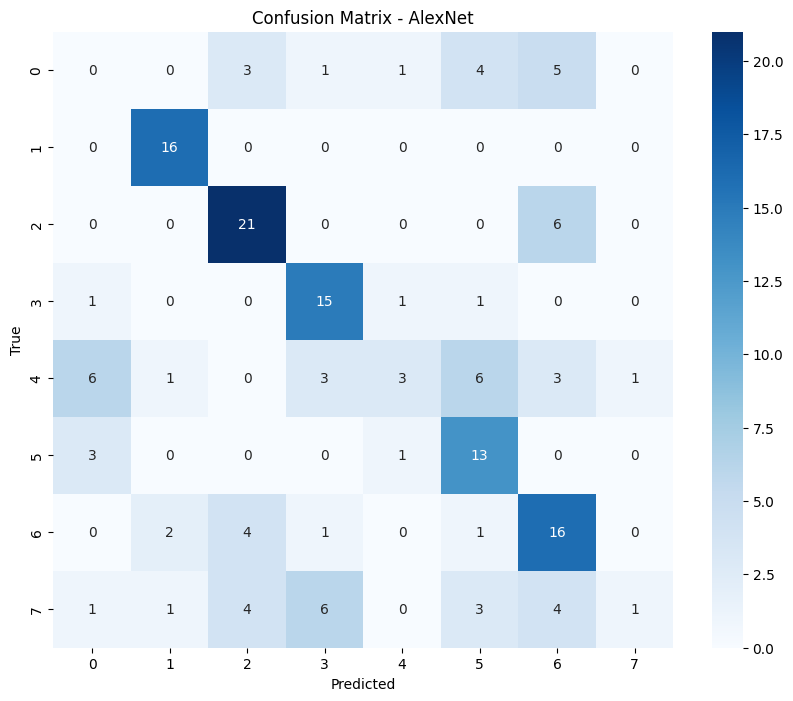

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        14
           1       0.80      1.00      0.89        16
           2       0.66      0.78      0.71        27
           3       0.58      0.83      0.68        18
           4       0.50      0.13      0.21        23
           5       0.46      0.76      0.58        17
           6       0.47      0.67      0.55        24
           7       0.50      0.05      0.09        20

    accuracy                           0.53       159
   macro avg       0.50      0.53      0.46       159
weighted avg       0.51      0.53      0.47       159



In [19]:
# Mengumpulkan label sebenarnya dan prediksi
true_labels = []
predicted_labels = []

# Tidak perlu melacak gradien saat melakukan evaluasi
with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = alexnet(images)
        _, predicted = torch.max(outputs, 1)
        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(predicted.cpu().numpy())

# Hitung confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Tampilkan confusion matrix dengan heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - AlexNet')
plt.show()

# Tampilkan laporan klasifikasi
report = classification_report(true_labels, predicted_labels)
print(report)

In [20]:
# Menghitung TP, FP, TN, dan FN untuk setiap label
for i in range(conf_matrix.shape[0]):
    tp = conf_matrix[i, i]
    fp = conf_matrix[:, i].sum() - tp
    fn = conf_matrix[i, :].sum() - tp
    tn = conf_matrix.sum() - (tp + fp + fn)

    # Menampilkan nilai untuk setiap label
    print(f'Label {i+1}:')
    print(f'True Positive (TP): {tp}')
    print(f'False Positive (FP): {fp}')
    print(f'True Negative (TN): {tn}')
    print(f'False Negative (FN): {fn}')
    print()

Label 1:
True Positive (TP): 0
False Positive (FP): 11
True Negative (TN): 134
False Negative (FN): 14

Label 2:
True Positive (TP): 16
False Positive (FP): 4
True Negative (TN): 139
False Negative (FN): 0

Label 3:
True Positive (TP): 21
False Positive (FP): 11
True Negative (TN): 121
False Negative (FN): 6

Label 4:
True Positive (TP): 15
False Positive (FP): 11
True Negative (TN): 130
False Negative (FN): 3

Label 5:
True Positive (TP): 3
False Positive (FP): 3
True Negative (TN): 133
False Negative (FN): 20

Label 6:
True Positive (TP): 13
False Positive (FP): 15
True Negative (TN): 127
False Negative (FN): 4

Label 7:
True Positive (TP): 16
False Positive (FP): 18
True Negative (TN): 117
False Negative (FN): 8

Label 8:
True Positive (TP): 1
False Positive (FP): 1
True Negative (TN): 138
False Negative (FN): 19



#### ResNet50

In [21]:
# Ambil dataset asli sebelum dibagi
original_dataset = train_dataset.dataset

# Hitung jumlah kelas dari dataset asli
num_classes = len(original_dataset.classes)

# Membuat model baru untuk klasifikasi
resnet50 = models.resnet50(pretrained=True)
num_features = resnet50.fc.in_features
resnet50.fc = nn.Linear(num_features, num_classes)

# Definisikan loss function dan optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(resnet50.parameters(), lr=0.001)

# Menentukan device yang akan digunakan
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Memindahkan model ke device yang dipilih
resnet50 = resnet50.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


TRAINING MODEL Resnet50

In [22]:
# Definisikan jumlah epoch
num_epochs = 10

# Loop pelatihan untuk setiap epoch
for epoch in range(num_epochs):
    # Set model ke mode pelatihan
    resnet50.train()

    # Inisialisasi nilai loss dan jumlah batch yang benar
    running_loss = 0.0
    correct = 0

    # Loop pelatihan untuk setiap batch dalam DataLoader
    for images, labels in train_loader:
        # Memindahkan data ke device yang dipilih
        images, labels = images.to(device), labels.to(device)

        # Reset gradien parameter
        optimizer.zero_grad()

        # Proses forward pass: menghitung output dari model
        outputs = resnet50(images)

        # Hitung loss
        loss = criterion(outputs, labels)

        # Proses backward pass: hitung gradien dari loss terhadap parameter
        loss.backward()

        # Optimize parameter
        optimizer.step()

        # Hitung statistik untuk logging
        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()

    # Hitung rata-rata loss dan akurasi untuk epoch ini
    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_acc = correct / len(train_loader.dataset)

    # Cetak statistik pelatihan untuk setiap epoch
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}')

Epoch 1/10, Loss: 0.7069, Accuracy: 0.7783
Epoch 2/10, Loss: 0.4865, Accuracy: 0.8553
Epoch 3/10, Loss: 0.4698, Accuracy: 0.8774
Epoch 4/10, Loss: 0.3263, Accuracy: 0.9041
Epoch 5/10, Loss: 0.3893, Accuracy: 0.8836
Epoch 6/10, Loss: 0.2595, Accuracy: 0.9214
Epoch 7/10, Loss: 0.3670, Accuracy: 0.8994
Epoch 8/10, Loss: 0.3257, Accuracy: 0.9072
Epoch 9/10, Loss: 0.2922, Accuracy: 0.9261
Epoch 10/10, Loss: 0.1919, Accuracy: 0.9371


MODEL EVALUATION ResNet

In [23]:
# Set model ke mode evaluasi
resnet50.eval()

# Inisialisasi variabel untuk evaluasi
correct = 0
total = 0

# Tidak perlu melacak gradien saat melakukan evaluasi
with torch.no_grad():
    for images, labels in val_loader:
        # Memindahkan data ke device yang dipilih
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = resnet50(images)

        # Ambil prediksi
        _, predicted = torch.max(outputs, 1)

        # Hitung jumlah data yang diprediksi dengan benar
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

# Hitung akurasi
accuracy = correct / total
print(f'Accuracy on validation set of ResNet50 Model: {accuracy:.2f}')

Accuracy on validation set of ResNet50 Model: 0.96


MODEL REPORTS ResNet

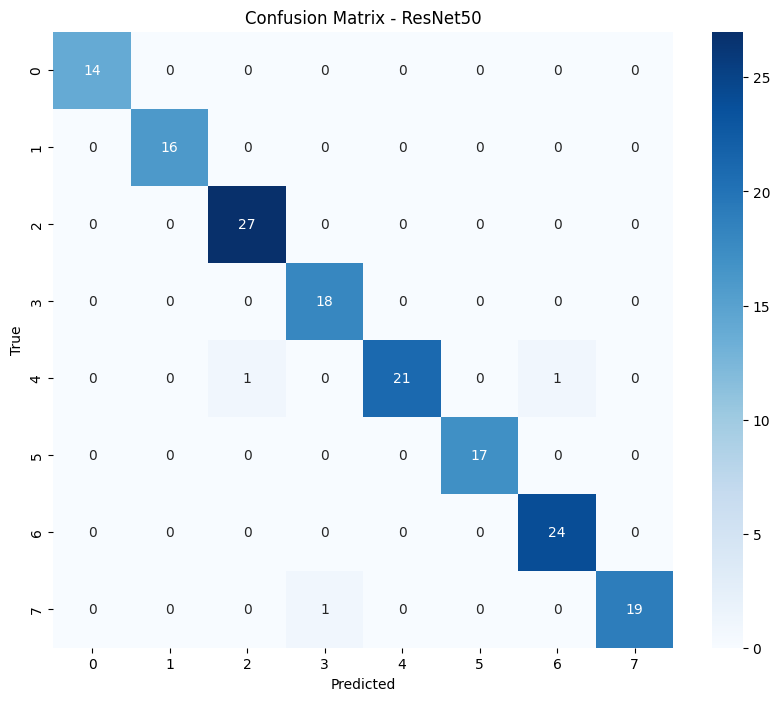

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        14
           1       1.00      1.00      1.00        16
           2       0.96      1.00      0.98        27
           3       0.95      1.00      0.97        18
           4       1.00      0.91      0.95        23
           5       1.00      1.00      1.00        17
           6       0.96      1.00      0.98        24
           7       1.00      0.95      0.97        20

    accuracy                           0.98       159
   macro avg       0.98      0.98      0.98       159
weighted avg       0.98      0.98      0.98       159



In [24]:
# Mengumpulkan label sebenarnya dan prediksi
true_labels = []
predicted_labels = []

# Tidak perlu melacak gradien saat melakukan evaluasi
with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = resnet50(images)
        _, predicted = torch.max(outputs, 1)
        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(predicted.cpu().numpy())

# Hitung confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Tampilkan confusion matrix dengan heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - ResNet50')
plt.show()

# Tampilkan laporan klasifikasi
report = classification_report(true_labels, predicted_labels)
print(report)

In [25]:
# Menghitung TP, FP, TN, dan FN untuk setiap label
for i in range(conf_matrix.shape[0]):
    tp = conf_matrix[i, i]
    fp = conf_matrix[:, i].sum() - tp
    fn = conf_matrix[i, :].sum() - tp
    tn = conf_matrix.sum() - (tp + fp + fn)

    # Menampilkan nilai untuk setiap label
    print(f'Label {i+1}:')
    print(f'True Positive (TP): {tp}')
    print(f'False Positive (FP): {fp}')
    print(f'True Negative (TN): {tn}')
    print(f'False Negative (FN): {fn}')
    print()

Label 1:
True Positive (TP): 14
False Positive (FP): 0
True Negative (TN): 145
False Negative (FN): 0

Label 2:
True Positive (TP): 16
False Positive (FP): 0
True Negative (TN): 143
False Negative (FN): 0

Label 3:
True Positive (TP): 27
False Positive (FP): 1
True Negative (TN): 131
False Negative (FN): 0

Label 4:
True Positive (TP): 18
False Positive (FP): 1
True Negative (TN): 140
False Negative (FN): 0

Label 5:
True Positive (TP): 21
False Positive (FP): 0
True Negative (TN): 136
False Negative (FN): 2

Label 6:
True Positive (TP): 17
False Positive (FP): 0
True Negative (TN): 142
False Negative (FN): 0

Label 7:
True Positive (TP): 24
False Positive (FP): 1
True Negative (TN): 134
False Negative (FN): 0

Label 8:
True Positive (TP): 19
False Positive (FP): 0
True Negative (TN): 139
False Negative (FN): 1



### MODEL EVALUATIONS

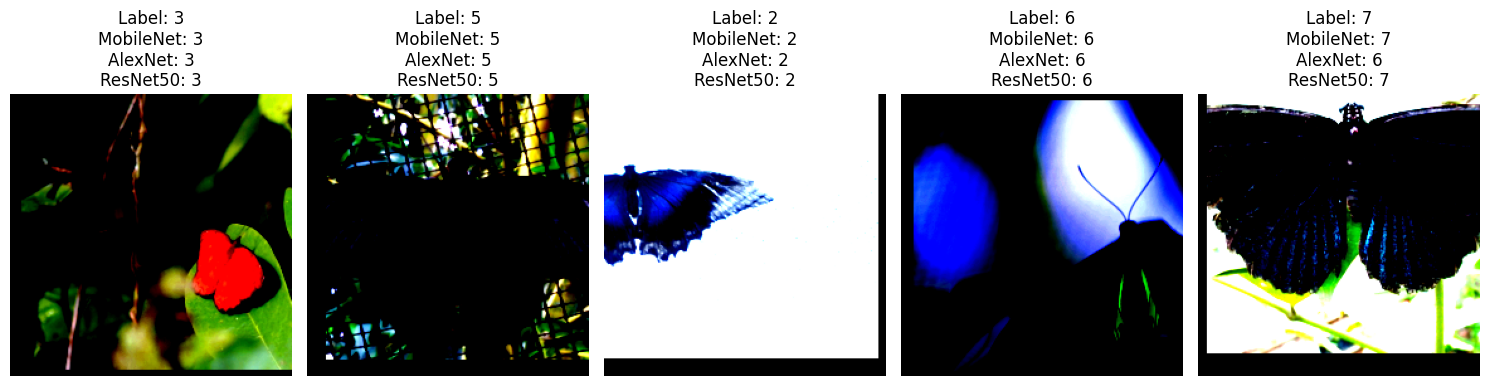

In [26]:
import matplotlib.pyplot as plt
import numpy as np

# Set model ke mode evaluasi
mobilenet_v2.eval()
alexnet.eval()
resnet50.eval()

# Inisialisasi variabel untuk menyimpan hasil prediksi
sample_images = []
sample_labels = []
sample_predictions_mobilenet = []
sample_predictions_alexnet = []
sample_predictions_resnet50 = []

# Memilih beberapa sampel gambar
num_samples = 5  # Ubah sesuai kebutuhan
samples_count = 0

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)

        # Forward pass untuk MobileNetV2
        outputs_mobilenet = mobilenet_v2(images)
        _, predicted_mobilenet = torch.max(outputs_mobilenet, 1)

        # Forward pass untuk AlexNet
        outputs_alexnet = alexnet(images)
        _, predicted_alexnet = torch.max(outputs_alexnet, 1)

        # Forward pass untuk ResNet50
        outputs_resnet50 = resnet50(images)
        _, predicted_resnet50 = torch.max(outputs_resnet50, 1)

        for i in range(len(labels)):
            if samples_count >= num_samples:
                break

            # Ambil data gambar, label, dan prediksi
            sample_images.append(images[i].cpu())
            sample_labels.append(labels[i].item())
            sample_predictions_mobilenet.append(predicted_mobilenet[i].item())
            sample_predictions_alexnet.append(predicted_alexnet[i].item())
            sample_predictions_resnet50.append(predicted_resnet50[i].item())

            samples_count += 1

        if samples_count >= num_samples:
            break

# Menampilkan hasil prediksi untuk setiap sampel
plt.figure(figsize=(15, 8))
for i in range(num_samples):
    plt.subplot(2, num_samples, i + 1)
    plt.imshow(sample_images[i].permute(1, 2, 0))  # Gambar perlu diubah urutannya untuk matplotlib
    plt.axis('off')
    plt.title(f'Label: {sample_labels[i]}\nMobileNet: {sample_predictions_mobilenet[i]}\nAlexNet: {sample_predictions_alexnet[i]}\nResNet50: {sample_predictions_resnet50[i]}')

plt.tight_layout()
plt.show()
